# Class 1

In [34]:
##Get packages:
import pymc as pm
import arviz as az
import numpy as np
# Provide data
n = 300
y = 200
# Model

with pm.Model() as binom_model:
    p = pm.Beta("p", alpha=1, beta=1) ### Prior distribution
    y_obs = pm.Binomial("y_obs", n=n, p=p, observed=y) ### Sampling distribution
    trace = pm.sample(2000, return_inferencedata=True, random_seed=12976) ### Run the code
az.summary(trace) ### Summary

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.666,0.028,0.614,0.717,0.001,0.0,2983.0,4664.0,1.0


# In class 2

In [7]:

import pandas as pd
import yfinance as yf
import pymc as pm
import math
import scipy.stats as stats
import matplotlib.pyplot as plt

stocks  = pd.read_csv("data/stocks.csv").drop(0)
# Define the data
n = len(stocks)
y = stocks['aapl_r'].values
# Define the PyMC model
with pm.Model() as model:
    # Priors
    mu = pm.Normal('mu', mu=0, sigma=100)
    sigma2 = pm.InverseGamma('sigma2', alpha=0.001, beta=0.001)
    # Likelihood
    y_lik = pm.Normal('y_lik', mu=mu, sigma=pm.math.sqrt(sigma2),
    observed=y)
    # Sample posterior
    trace = pm.sample(1000, tune=500) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma2]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 38 seconds.


In [16]:
import numpy as np
import arviz as az
posterior_mu = trace.posterior["mu"].values.flatten()
posterior_sigma2= trace.posterior["sigma2"].values.flatten()
# Calculate 1% quantile
one_per = stats.norm.ppf(0.01, loc=posterior_mu,
scale=np.sqrt(posterior_sigma2))


In [37]:
quants = pd.Series(one_per).quantile([.025,.975])

quants.loc[len(quants)] = one_per.mean()

In [38]:
for quant in quants: 
     print(quant * 1000.0 * stocks['Close'].tail(1).astype(float))

200   -8920.576604
Name: Close, dtype: float64
200   -7079.972666
Name: Close, dtype: float64
200   -7961.816372
Name: Close, dtype: float64


In [14]:
stocks['Close'].tail(1)

200    218.27000427246094
Name: Close, dtype: object

In [ ]:
posterior_mu = trace.posterior["mu"].values.flatten()
posterior_sigma2= trace.posterior["sigma2"].values.flatten()
# Calculate 1% quantile
one_per = stats.norm.ppf(0.01, loc=posterior_mu,
scale=np.sqrt(posterior_sigma2))
# Plot histogram of 1% quantile
plt.hist(one_per, bins=30, density=False, alpha=0.5)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 1% Quantile')
plt.grid(True)
plt.show()

# Quiz 2

In [ ]:
import pandas as pd
import yfinance as yf
import pymc as pm
import math
import scipy.stats as stats
import matplotlib.pyplot as plt

stocks = pd.read_csv("data/stocks.csv").drop(0)

import numpy as np

# Assuming 'data' is your observed data, where you know the standard deviation for your data
# Example of generating data (replace this with your actual data):
# Set the seed for reproducibility
np.random.seed(69321)

# PyMC3 Model
with pm.Model() as model:
    # Priors
    mu = pm.Normal('mu', mu=0, sigma=100)  # Normal prior for mu
    sigma2 = pm.InverseGamma('sigma2', alpha=0.01, beta=0.01)  # Inverse-Gamma prior for sigma^2
    
    # Likelihood (assuming normal distribution of data with unknown mu and sigma)
    likelihood = pm.Normal('y', mu=mu, sigma=np.sqrt(sigma2), observed=stocks)
    
    # Sampling
    trace = pm.sample(3000, chains=4, burnin=1000, random_seed=69321)
    
# Extract posterior samples for mu
posterior_mu = trace['mu']

# Calculate the mean of the posterior distribution for mu
posterior_mu_mean = np.mean(posterior_mu)

print(f"The mean of the posterior distribution for mu is: {posterior_mu_mean:.4f}")


Initializing NUTS using jitter+adapt_diag...


# In class 3

In [29]:
import pandas as pd

data = pd.read_csv("data/BreastCancer.csv")
data['response'] = (data['Class'] == 'malignant').astype(int)
# Drop the 'Id' column
data.drop(columns=['Class',"Id","Cell_size"], inplace=True)

# Convert explanatory variables to numeric
data.iloc[:, :-1] = data.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')

# Convert 'Class' column to categorical
#data['Class'] = data['Class'].astype('category')

# Check dataset info

In [30]:
b = data.corr()

for i in range(0,len(b)):
    for j in range(0,len(b.columns)):
        if b.iloc[i,j] > .9 and b.iloc[i,j] != 1:
            print("hey")
            print(i,j)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = data.columns
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

print(vif_data)


           Feature       VIF
0     Cl_thickness  5.214930
1       Cell_shape  9.015521
2    Marg_adhesion  4.812071
3     Epith_c_size  6.719565
4      Bare_nuclei  6.322975
5      Bl_cromatin  7.429058
6  Normal_nucleoli  4.739754
7          Mitoses  2.564691
8         response  6.942301


In [32]:
data.columns

Index(['Cl_thickness', 'Cell_shape', 'Marg_adhesion', 'Epith_c_size',
       'Bare_nuclei', 'Bl_cromatin', 'Normal_nucleoli', 'Mitoses', 'response'],
      dtype='object')

In [46]:
import bambi as bmb

model = bmb.Model("response ~ Cl_thickness + Cell_shape + Marg_adhesion + Bare_nuclei + Bl_cromatin + Normal_nucleoli + Mitoses",
data=data,family="bernoulli")
fitModel = model.fit( draws=2000, random_seed=85208 ,
idata_kwargs={"log_likelihood": True})

import arviz as az

az.summary(fitModel, hdi_prob=0.95)
az.plot_trace(fitModel, compact=False);



Modeling the probability that response==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cl_thickness, Cell_shape, Marg_adhesion, Bare_nuclei, Bl_cromatin, Normal_nucleoli, Mitoses]


KeyboardInterrupt: 

In [ ]:
import arviz as az

az.summary(fitModel, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-9.646,0.970,-11.528,-7.756,0.010,0.010,9173.0,6953.0,1.0
Cl_thickness,0.505,0.123,0.270,0.746,0.001,0.001,9564.0,6091.0,1.0
Cell_shape,0.370,0.144,0.078,0.642,0.001,0.001,9480.0,6052.0,1.0
Marg_adhesion,0.323,0.109,0.120,0.548,0.001,0.001,10328.0,5982.0,1.0
Bare_nuclei,0.378,0.085,0.208,0.538,0.001,0.001,9071.0,6034.0,1.0
Bl_cromatin,0.441,0.147,0.158,0.738,0.001,0.002,10103.0,6816.0,1.0
Normal_nucleoli,0.234,0.101,0.037,0.436,0.001,0.001,10303.0,6545.0,1.0
Mitoses,0.476,0.228,0.045,0.914,0.002,0.002,9687.0,6568.0,1.0


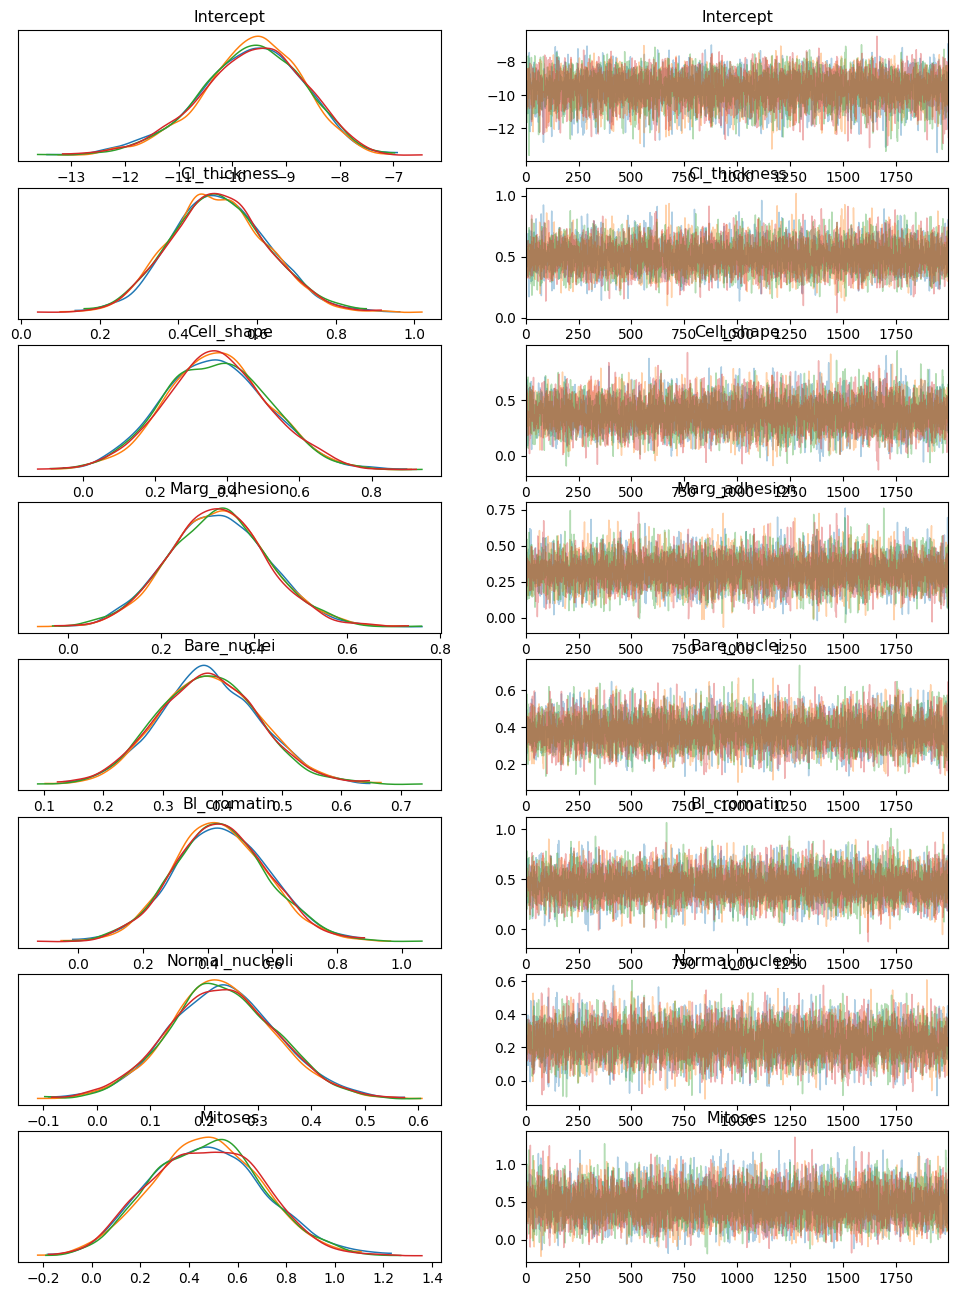

In [44]:
az.plot_trace(fitModel, compact=False);


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-9.646,0.970,-11.542,-7.928,0.010,0.010,9173.0,6953.0,1.0
Cl_thickness,0.505,0.123,0.284,0.742,0.001,0.001,9564.0,6091.0,1.0
Cell_shape,0.370,0.144,0.099,0.642,0.001,0.001,9480.0,6052.0,1.0
Marg_adhesion,0.323,0.109,0.122,0.532,0.001,0.001,10328.0,5982.0,1.0
Bare_nuclei,0.378,0.085,0.215,0.531,0.001,0.001,9071.0,6034.0,1.0
Bl_cromatin,0.441,0.147,0.172,0.728,0.001,0.002,10103.0,6816.0,1.0
Normal_nucleoli,0.234,0.101,0.038,0.420,0.001,0.001,10303.0,6545.0,1.0
Mitoses,0.476,0.228,0.069,0.910,0.002,0.002,9687.0,6568.0,1.0
